In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.4

matplotlib.rcParams['xtick.major.size'] = 0.5 # length of major xticks
matplotlib.rcParams['xtick.major.width'] = 0.25   # width of major xticks
matplotlib.rcParams['ytick.major.size'] = 0.5  # length of major yticks
matplotlib.rcParams['ytick.major.width'] = 0.25   # width of major yticks


# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

import copy
from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta
from sparrow.data.amino_acids import VALID_AMINO_ACIDS

In [2]:
from finches.frontend.mpipi_frontend import Mpipi_frontend
from finches.frontend.calvados_frontend import CALVADOS_frontend
mf = Mpipi_frontend()
cf = CALVADOS_frontend()

/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [3]:
test_seqs = {}
test_seqs['fus'] = 'MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNS'
test_seqs['A1_LCD'] = 'MASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFGGRSSGPYGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF'
test_seqs['laf_1'] = 'MESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRGGAGGGGYRRGGGNSGGGGGGGYDRGYNDNRDDRDNRGGSGGYGRDRNYEDRGYNGGGGGGGNRGYNNNRGGGGGGYNRQDRGDGGSSNFSRGGYNNRDEGSDNRGSGRSYNNDRRDNGGD'
test_seqs['ddx4'] = 'MGDEDWEAEINPHMSSYVPIFEKDRYSGENGDNFNRTPASSSEMDDGPSRRDHFMKSGFASGRNFGNRDAGECNKRDNTSTMGGFGVGKSFGNRGFSNSRFEDGDSSGFWRESSNDCEDNPTRNRGFSKRGGYRDGNNSEASGPYRRGGRGSFRGCRGGFGLGSPNNDLDPDECMQRTGGLFGSRRPVLSGTGNGDTSQSRSGSGSERGGYKGLNEEVITGSGKNSWKSEAEGG'
test_seqs['brca1'] = 'DQELLQITPQGTRDEISLDSAKKAACEFSETDVTNTEHHQPSNNDLNTTEKRAAERHPEKYQGSSVSNLHVEPCGTNTHASSLQHENSSLLLTKDRMNVEKAEFCNKSKQPGLARSQHNRWAGSKETCNDRRTPSTEKKVDLNADPLCERKEWNKQKLPCSENPRDTEDVPWITLNSSIQKVNEWFSRSDELLGSDDSHD'

test_name = 'brca1'
test_seq  =  test_seqs[test_name]

# Perform local sensitivity analysis for Wang-Frenkel epsilon parameter
The code below performs a local sensitivity analysis to investigate how $\epsilon$ (epsilon) depends on   by stepping through the following steps:

1. We cycle through all non-redundant pairs of amino acids (recalling that the pairwise small-eps [which is what is defined by Mpipi] is symmetrical) and for each pair extract the 

In [4]:
base_mf = Mpipi_frontend()
base_big_eps = base_mf.IMC_object.calculate_epsilon_value(test_seq,test_seq)

# initialize
all_derivatives = {}
for aa in VALID_AMINO_ACIDS:
    all_derivatives[aa] = {}

# for each aa in the pair
for aa1_index in tqdm(range(20)):
    aa1 = VALID_AMINO_ACIDS[aa1_index]

    # for each (non-redudant) second aa in pair
    for aa2_index in range(aa1_index, 20):
        aa2 = VALID_AMINO_ACIDS[aa2_index]

        # get the "standard" small eps associated with these two residues
        basal_small_eps = base_mf.IMC_object.parameters.EPSILON_ALL[aa1][aa2]

        # calculate four values +/- 5 and 10% of the standard (basal) value
        down_5pcnt = basal_small_eps - 5*(basal_small_eps/100)
        down_10pcnt = basal_small_eps - 10*(basal_small_eps/100)
        up_5pcnt = basal_small_eps + 5*(basal_small_eps/100)
        up_10pcnt = basal_small_eps + 10*(basal_small_eps/100)

        # build a local copy of the 
        mf = copy.deepcopy(base_mf)
        tmp = []
        for updated_small_eps in [down_10pcnt, down_5pcnt, basal_small_eps, up_5pcnt, up_10pcnt]:
            
            mf.IMC_object.parameters.EPSILON_ALL[aa1][aa2] = updated_small_eps
            mf.IMC_object._update_lookup_dict() 

            # NOTE - it's important we do not use aliphatic weighting here, as the underlying aliphatic
            # cluster residues are not simultaneously being updated; we could update the code to do this, but
            # in the spirit of exploring how individual parameters influence big epsilon dependence this was
            # not seen as a crucial feature. We do use charge weighting, however, as this has a big effect and
            # is dealt with intrinsically (charge-dependence calculated later in this notebook)
            tmp.append(mf.IMC_object.calculate_epsilon_value(test_seq,test_seq, use_aliphatic_weighting=False))
            
        d_eps_d_small_eps = np.polyfit([-10,-5,0,5,10],tmp, 1)[0]
        all_derivatives[aa1][aa2] = d_eps_d_small_eps
        
    
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.64s/it]


In [5]:
master_sensitivity = {}
fraction_aas = []

for aa1_index in range(20):
    for aa2_index in range(aa1_index, 20):

        aa1 = VALID_AMINO_ACIDS[aa1_index]
        aa2 = VALID_AMINO_ACIDS[aa2_index]
    
        name = f'{aa1}-{aa2}'
        master_sensitivity[name] = abs(100*(all_derivatives[aa1][aa2]/base_big_eps))

        p = Protein(test_seq)
        fract_aa1 = p.amino_acid_fractions[aa1]
        fract_aa2 = p.amino_acid_fractions[aa2]
        fraction_aas.append([name,fract_aa1+fract_aa2, master_sensitivity[name]])

# master_sensitivity_sorted now has rank ordered pairs reporting on the change in % of the OVERALL epsilon upon change in 
# the pair-wise epislon by 1%. Note that these are real percents, i.e. 0.79 = 0.79%, NOT 79% (!!!!)
master_sensitivity_sorted = dict(sorted(master_sensitivity.items(), key=lambda item: item[1], reverse=True))        

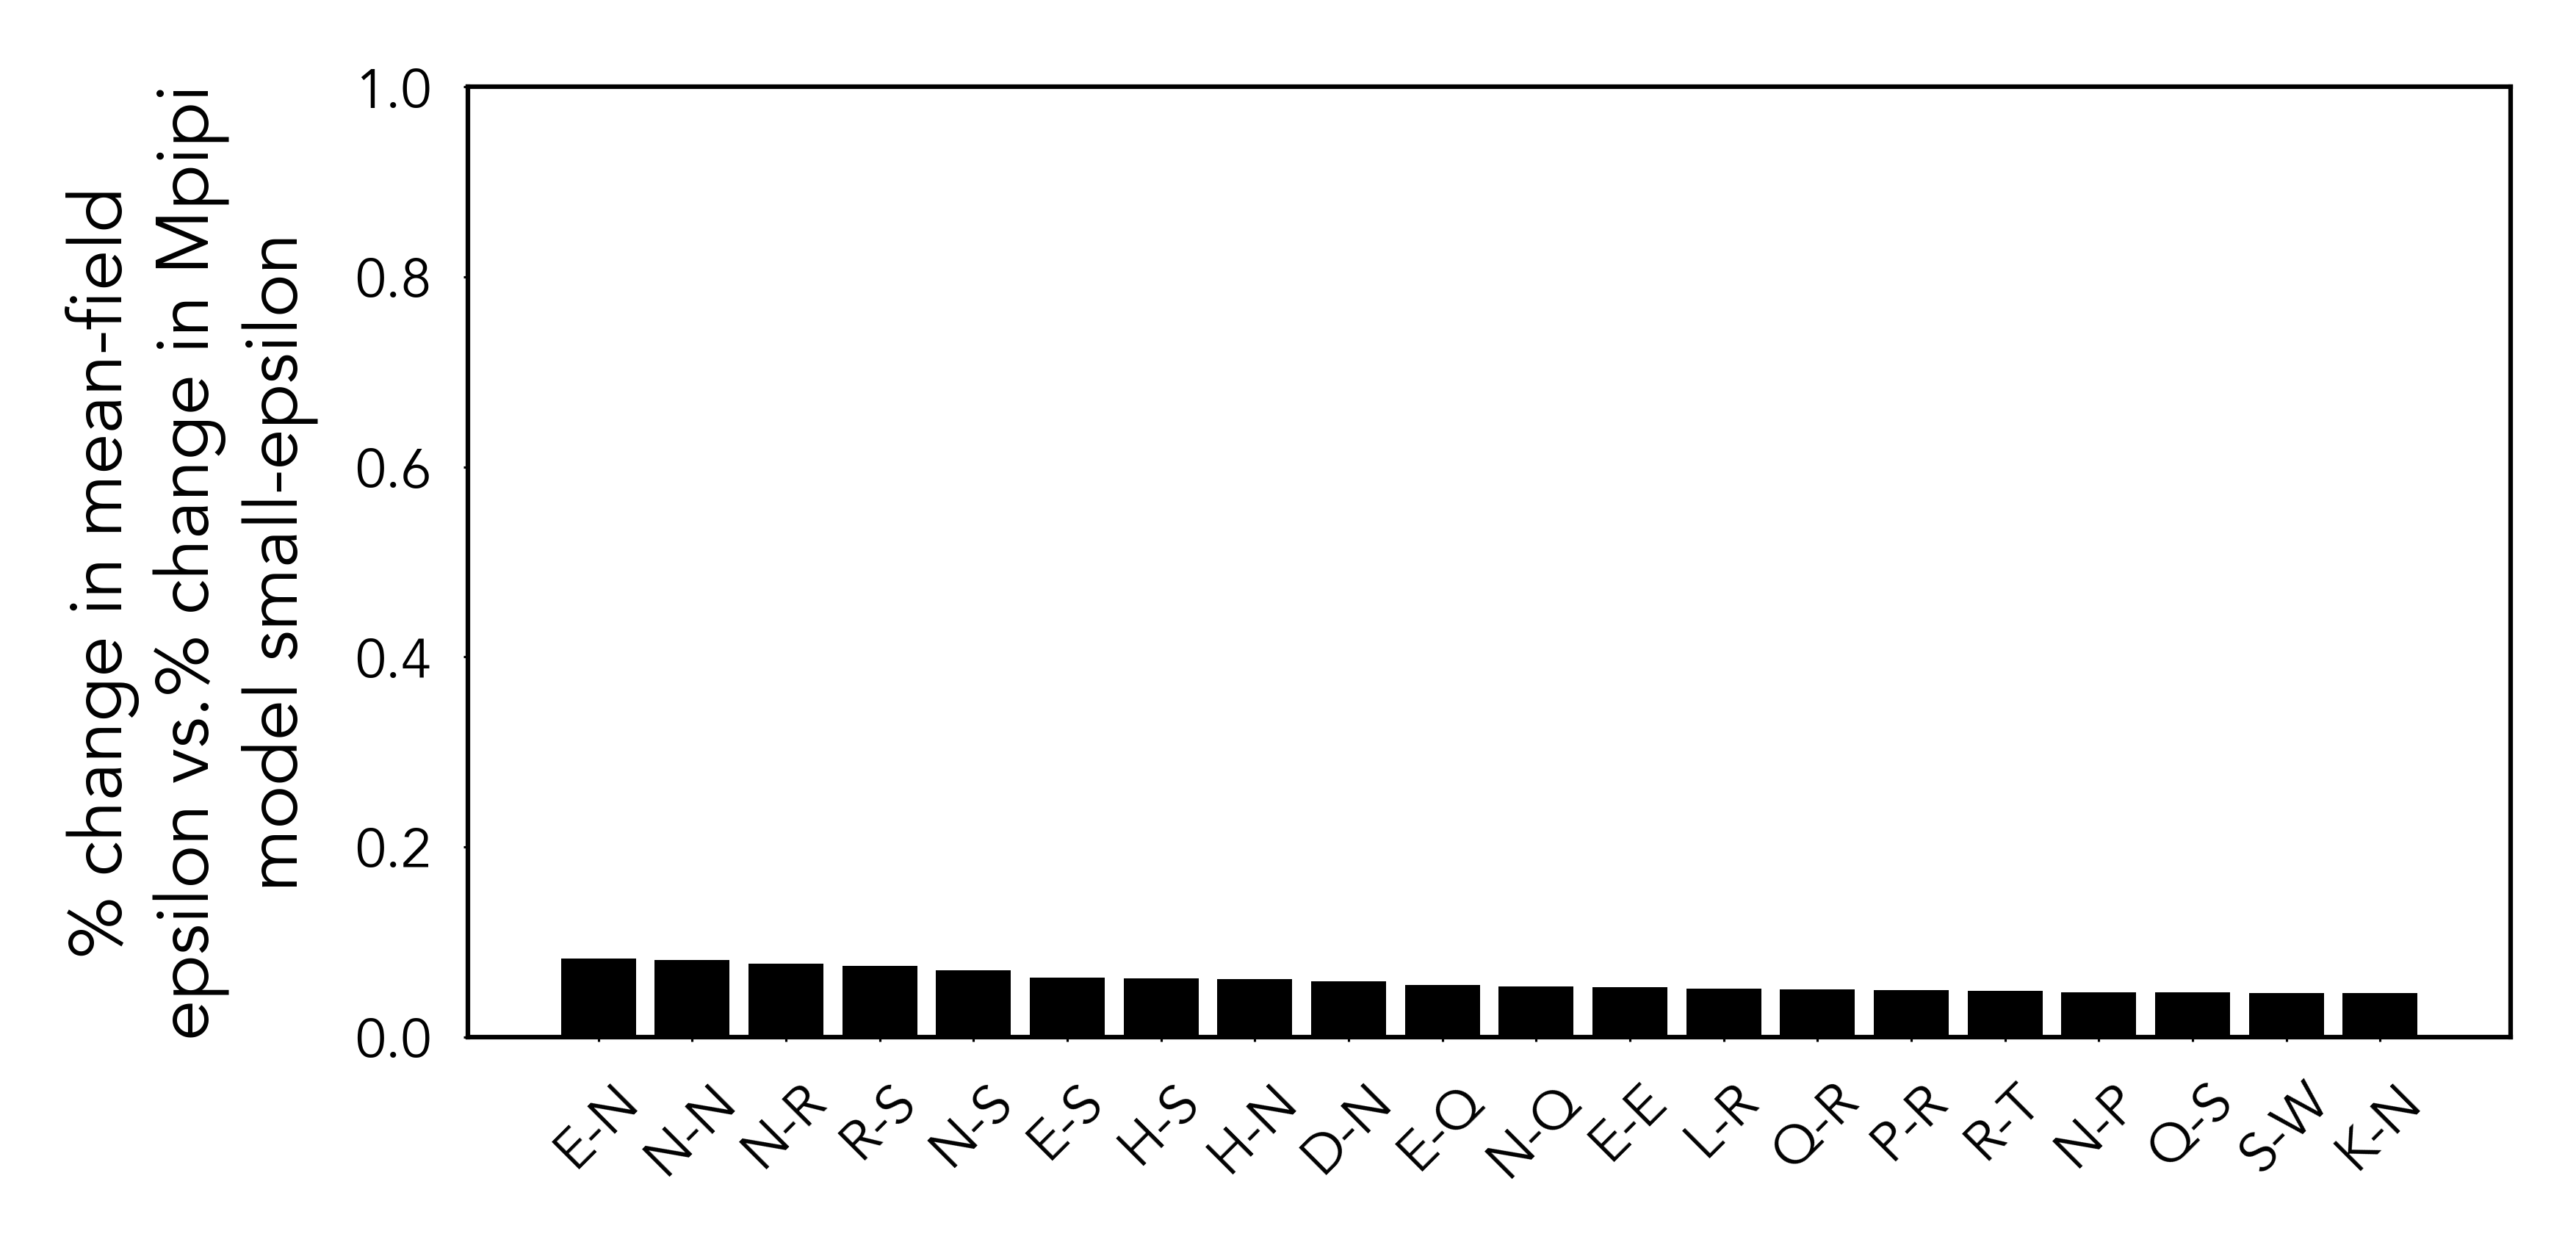

In [6]:
top_number = 20
indices = np.arange(1,top_number+1)
top_20_names = list(master_sensitivity_sorted.keys())[0:top_number]
top_20_values = np.array(list(master_sensitivity_sorted.values())[0:top_number])


figure(None, (4,2), dpi=450)
plt.bar(indices, top_20_values, color='k')
plt.xticks(indices, top_20_names, rotation=45, fontsize=6)

plt.yticks(fontsize=6)
plt.ylim([0,1])
plt.ylabel(f'% change in mean-field \n epsilon vs.% change in Mpipi \nmodel small-epsilon', fontsize=8)
plt.tight_layout()
plt.savefig(f'out_figures/sensitivity_1_{test_name}.pdf')


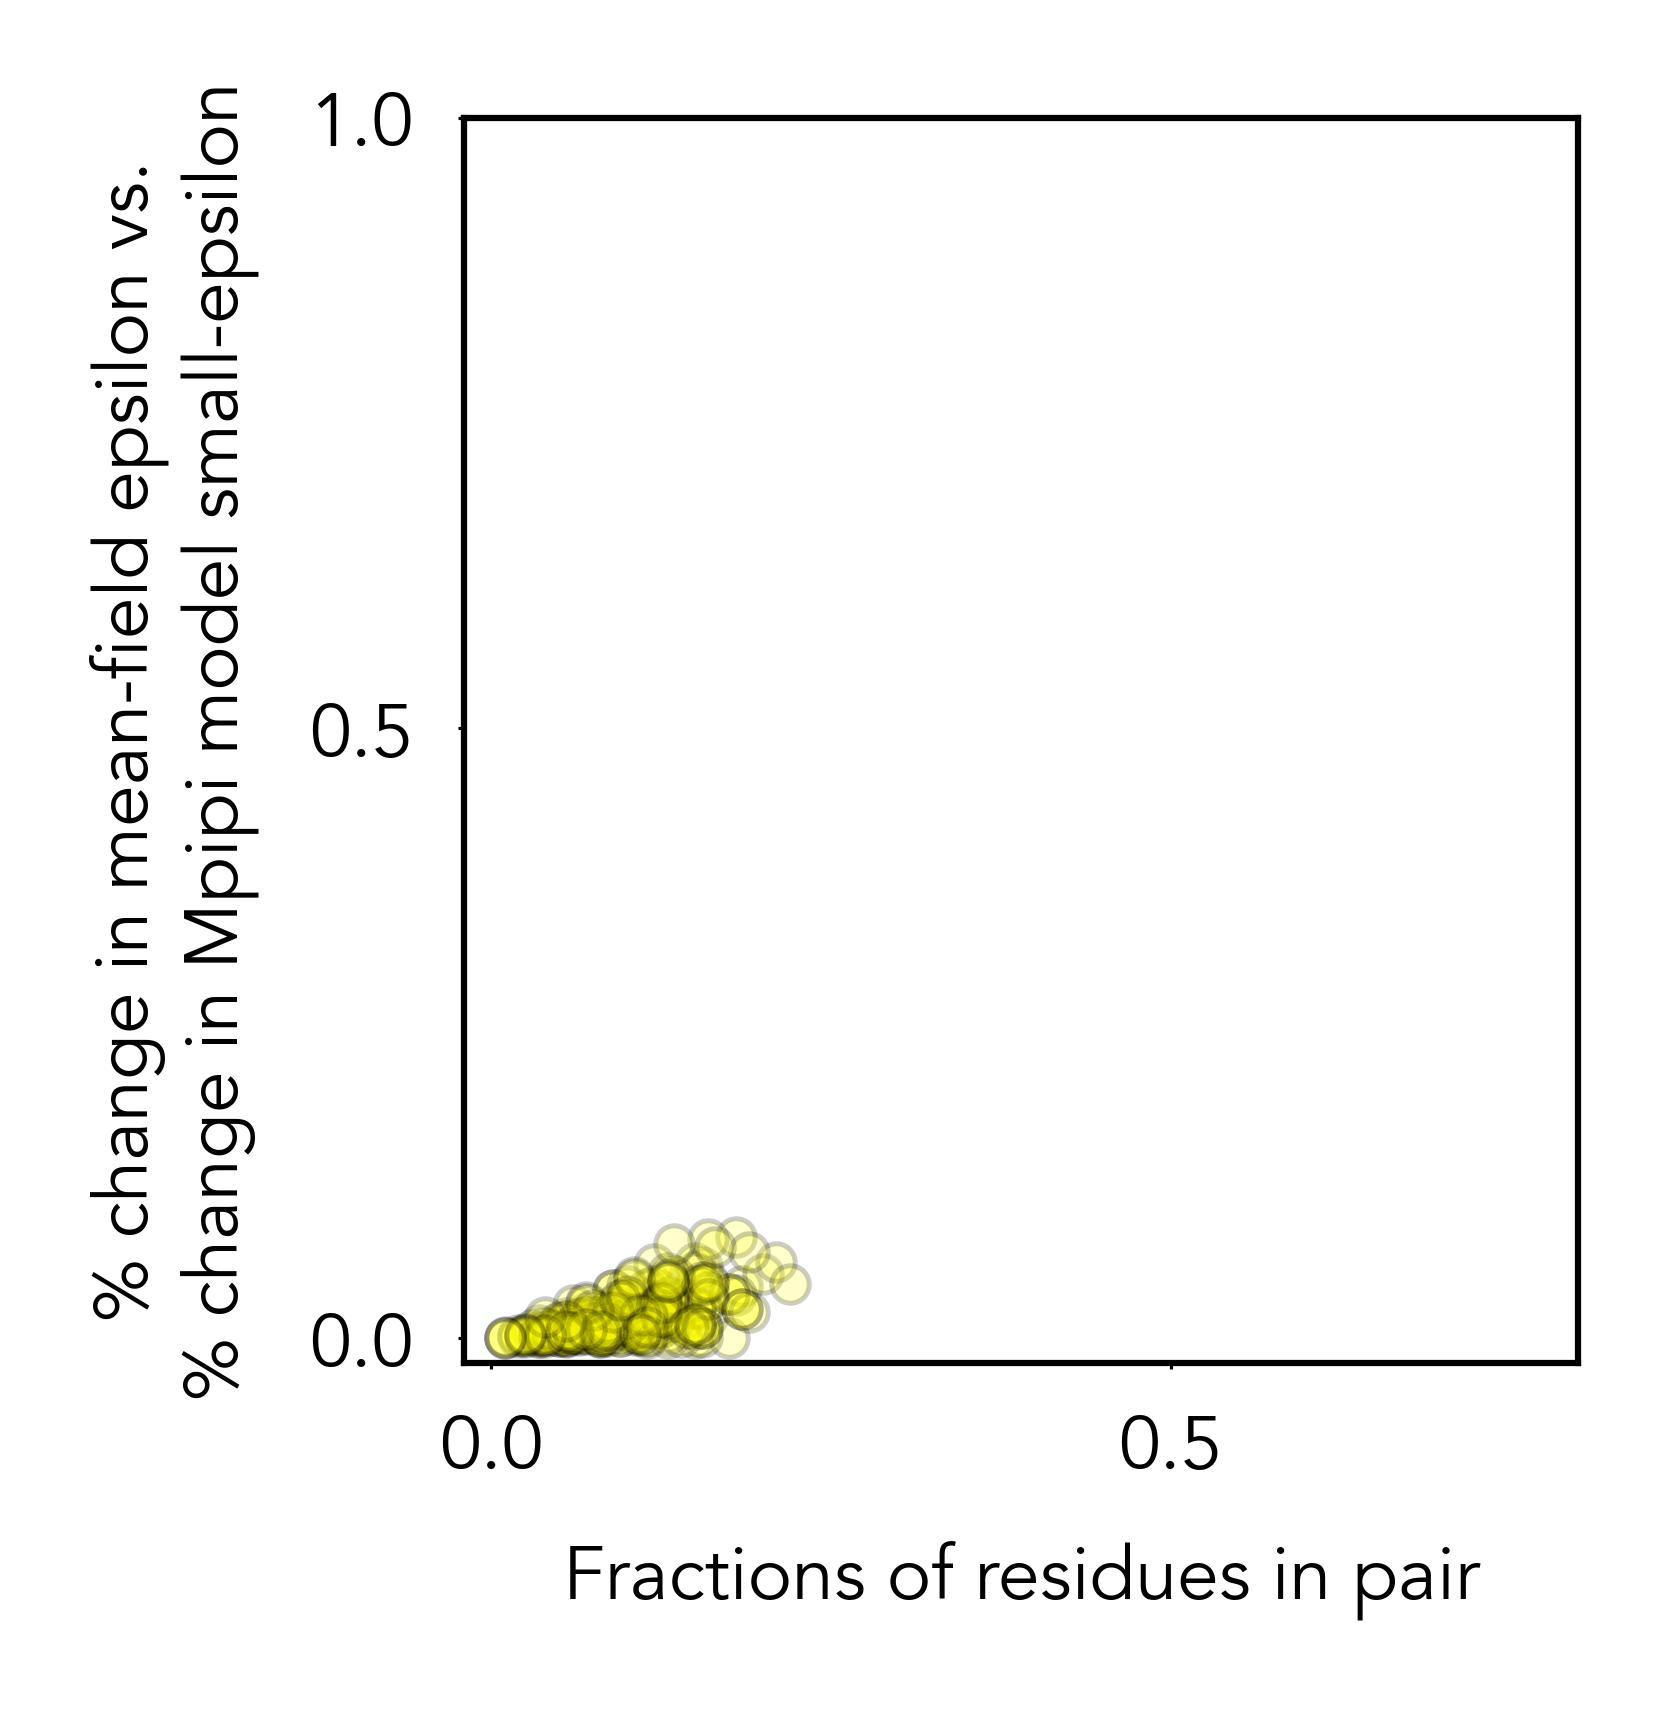

In [7]:
figure(None, (2,2), dpi=450)

summed_fractions = [x[1] for x in fraction_aas]
sensitivity = [x[2] for x in fraction_aas]
plt.plot(summed_fractions, sensitivity,'o', ms=3, alpha=0.2, mew=0.4, mec='k', color='yellow')

plt.xticks(fontsize=6)
plt.xlim([-0.02,0.8])
plt.yticks(fontsize=6)
plt.ylim([-0.02,1])
plt.ylabel(f'% change in mean-field epsilon vs.\n% change in Mpipi model small-epsilon', fontsize=6)
plt.xlabel(f'Fractions of residues in pair', fontsize=6)
plt.tight_layout()
plt.savefig(f'out_figures/sensitivity_2_{test_name}.pdf')


In [8]:
# initialize
all_derivatives_charge = {}
VALID_CHARGED_RES = ['E','D','R','K']
for aa in VALID_CHARGED_RES:
    all_derivatives_charge[aa] = {}

# for each aa in the pair
for aa1_index in tqdm(range(len(VALID_CHARGED_RES))):
    aa1 = VALID_CHARGED_RES[aa1_index]

    # for each (non-redudant) second aa in pair
    for aa2_index in range(aa1_index, len(VALID_CHARGED_RES)):
        aa2 = VALID_CHARGED_RES[aa2_index]

        # get the "standard" small eps associated with these two residues
        basal_charge = base_mf.IMC_object.parameters.CHARGE_ALL[aa1]
        

        # calculate four values +/- 5 and 10% of the standard (basal) value
        down_5pcnt = basal_charge - 5*(basal_charge/100)
        down_10pcnt = basal_charge - 10*(basal_charge/100)
        up_5pcnt = basal_charge + 5*(basal_charge/100)
        up_10pcnt = basal_charge + 10*(basal_charge/100)

        # build a local copy of the 
        mf = copy.deepcopy(base_mf)
        tmp = []
        for updated_charge in [down_10pcnt, down_5pcnt, basal_small_eps, up_5pcnt, up_10pcnt]:
            
            mf.IMC_object.parameters.CHARGE_ALL[aa1] = updated_charge
            mf.IMC_object._update_lookup_dict() 

            # NOTE - it's important we do not use aliphatic weighting here, as the underlying aliphatic
            # cluster residues are not simultaneously being updated; we could update the code to do this, but
            # in the spirit of exploring how individual parameters influence big epsilon dependence this was
            # not seen as a crucial feature. We do use charge weighting, however, as this has a big effect and
            # is dealt with intrinsically (charge-dependence calculated later in this notebook)
            tmp.append(mf.IMC_object.calculate_epsilon_value(test_seq,test_seq, use_aliphatic_weighting=False))
            
        d_eps_d_charge = np.polyfit([-10,-5,0,5,10],tmp, 1)[0]
        all_derivatives_charge[aa1][aa2] = d_eps_d_charge
        
    
        


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.51it/s]


In [9]:
master_sensitivity_charge = {}
fraction_aas_charge = []

for aa1_index in range(len(VALID_CHARGED_RES)):
    for aa2_index in range(aa1_index, len(VALID_CHARGED_RES)):

        aa1 = VALID_CHARGED_RES[aa1_index]
        aa2 = VALID_CHARGED_RES[aa2_index]
    
        name = f'{aa1}-{aa2}'
        master_sensitivity_charge[name] = abs(100*(all_derivatives_charge[aa1][aa2]/base_big_eps))

        p = Protein(test_seq)
        fract_aa1 = p.amino_acid_fractions[aa1]
        fract_aa2 = p.amino_acid_fractions[aa2]
        fraction_aas_charge.append([name,fract_aa1+fract_aa2, master_sensitivity_charge[name]])

# master_sensitivity_sorted now has rank ordered pairs reporting on the change in % of the OVERALL epsilon upon change in 
# the pair-wise epislon by 1%. Note that these are real percents, i.e. 0.79 = 0.79%, NOT 79% (!!!!)
master_sensitivity_charge_sorted = dict(sorted(master_sensitivity_charge.items(), key=lambda item: item[1], reverse=True))        

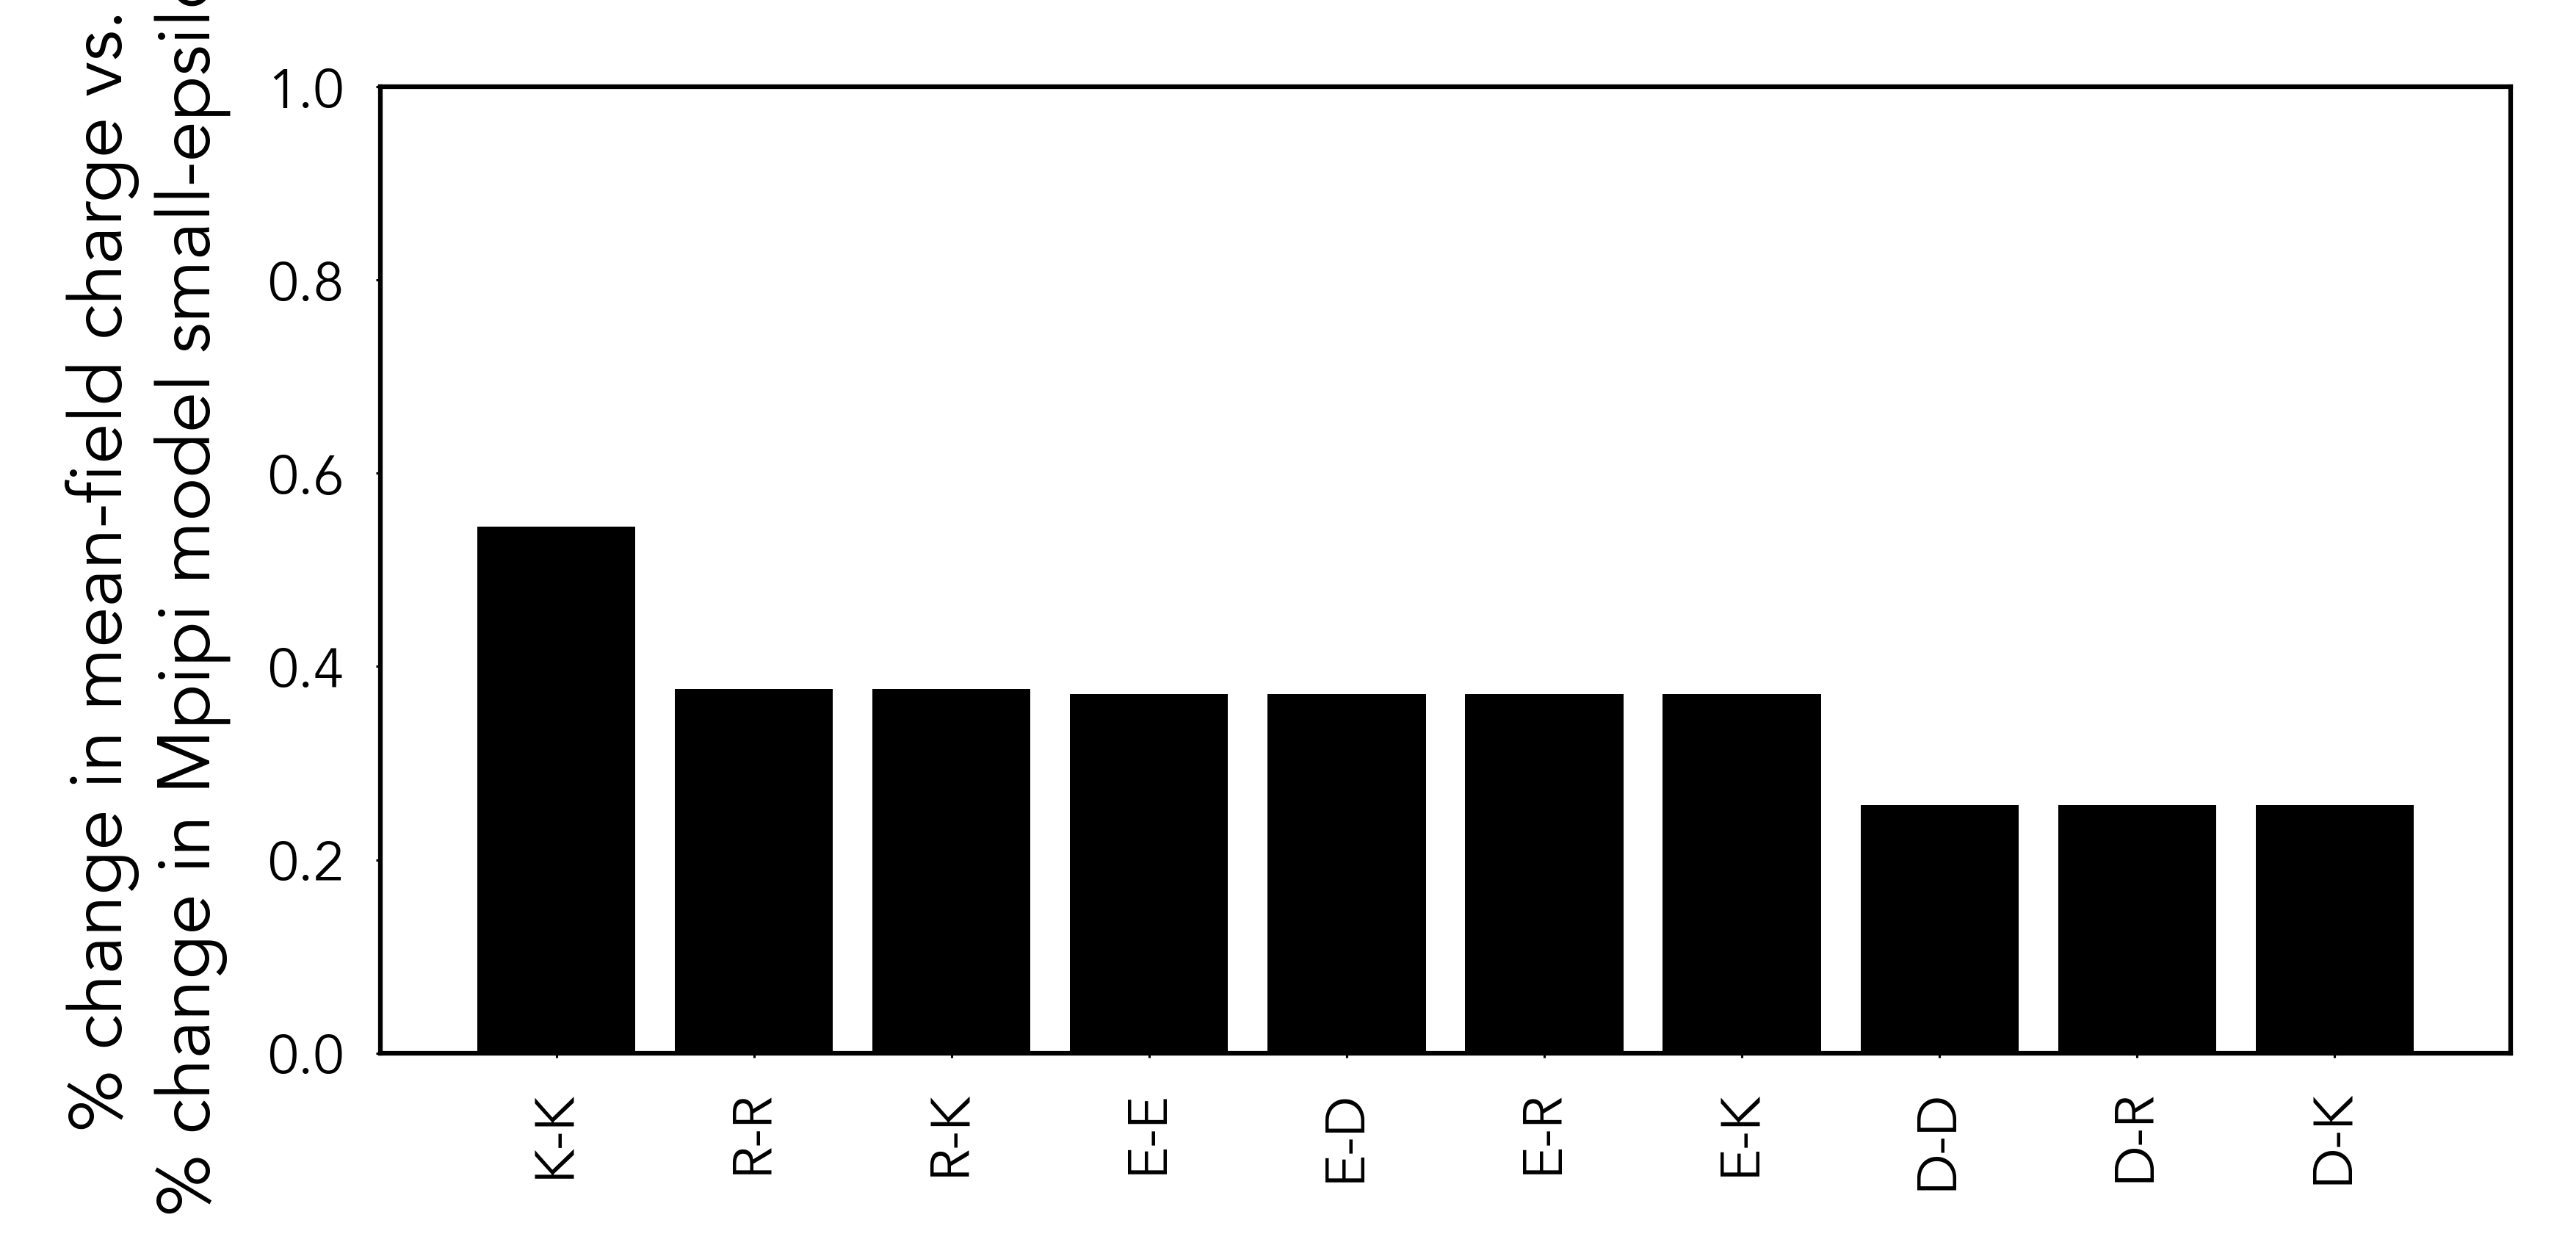

In [10]:
charge_count = len(master_sensitivity_charge_sorted)
indices = np.arange(1,charge_count+1)

top_charge_values = np.array(list(master_sensitivity_charge_sorted.values()))
top_charge_names = list(master_sensitivity_charge_sorted.keys())

figure(None, (4,2), dpi=450)
plt.bar(indices, top_charge_values, color='k')
plt.xticks(indices, top_charge_names, rotation=90, fontsize=6)

plt.yticks(fontsize=6)
plt.ylim([0,1])
plt.ylabel(f'% change in mean-field charge vs.\n% change in Mpipi model small-epsilon', fontsize=8)
plt.tight_layout()

plt.savefig(f'out_figures/charge_sensitivity_1_{test_name}.pdf')


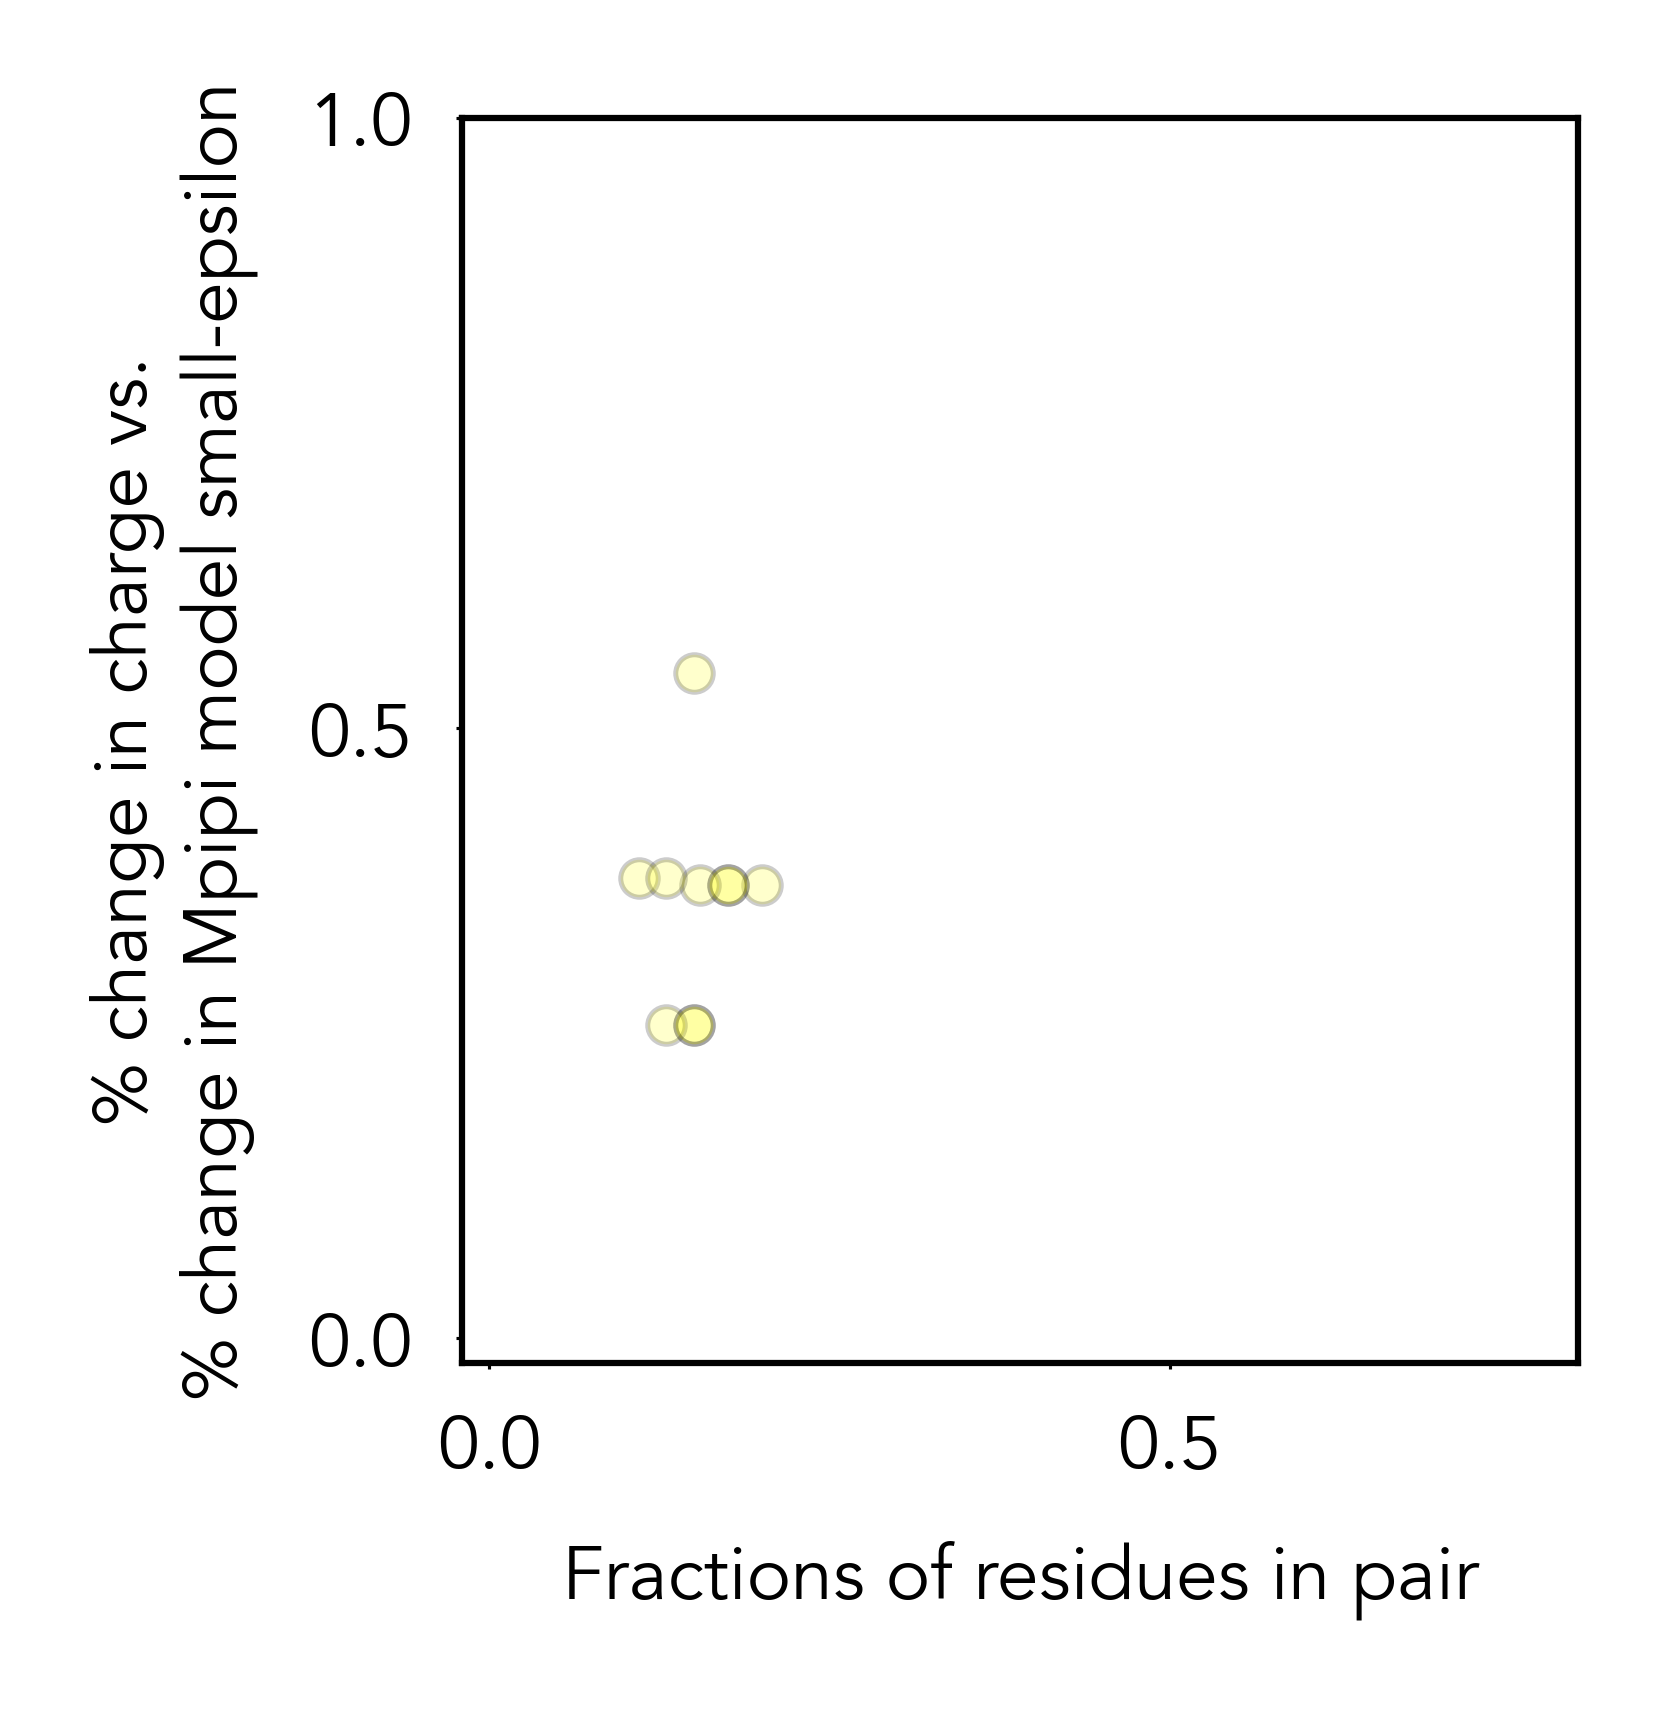

In [11]:
figure(None, (2,2), dpi=450)

summed_fractions = [x[1] for x in fraction_aas_charge]
sensitivity = [x[2] for x in fraction_aas_charge]
plt.plot(summed_fractions, sensitivity,'o', ms=3, alpha=0.2, mew=0.4, mec='k', color='yellow')

plt.xticks(fontsize=6)
plt.xlim([-0.02,0.8])
plt.yticks(fontsize=6)
plt.ylim([-0.02,1])
plt.ylabel(f'% change in charge vs.\n% change in Mpipi model small-epsilon', fontsize=6)
plt.xlabel(f'Fractions of residues in pair', fontsize=6)
plt.tight_layout()

plt.savefig(f'out_figures/charge_sensitivity_2_{test_name}.pdf')
